Importación de librerías

In [2]:
from sklearn.preprocessing import LabelEncoder
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn import feature_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
import lightgbm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Se carga el set de datos

In [26]:
df =  pd.read_csv(r'balanceo_1000.csv')
df.sample(n=10)
df_org =  pd.read_csv(r'balanceo_1000.csv')



**Análisis exploratorio de datos (EDA)**



In [22]:
print(f"The dataset contains { str(df.topic.unique()) } unique categories")

The dataset contains ['politica' 'economia' 'deportes' 'cultura' 'tecnosfera' 'vida'] unique categories


In [23]:
print(df.isnull().sum())

topic         0
text          0
date_query    0
dtype: int64


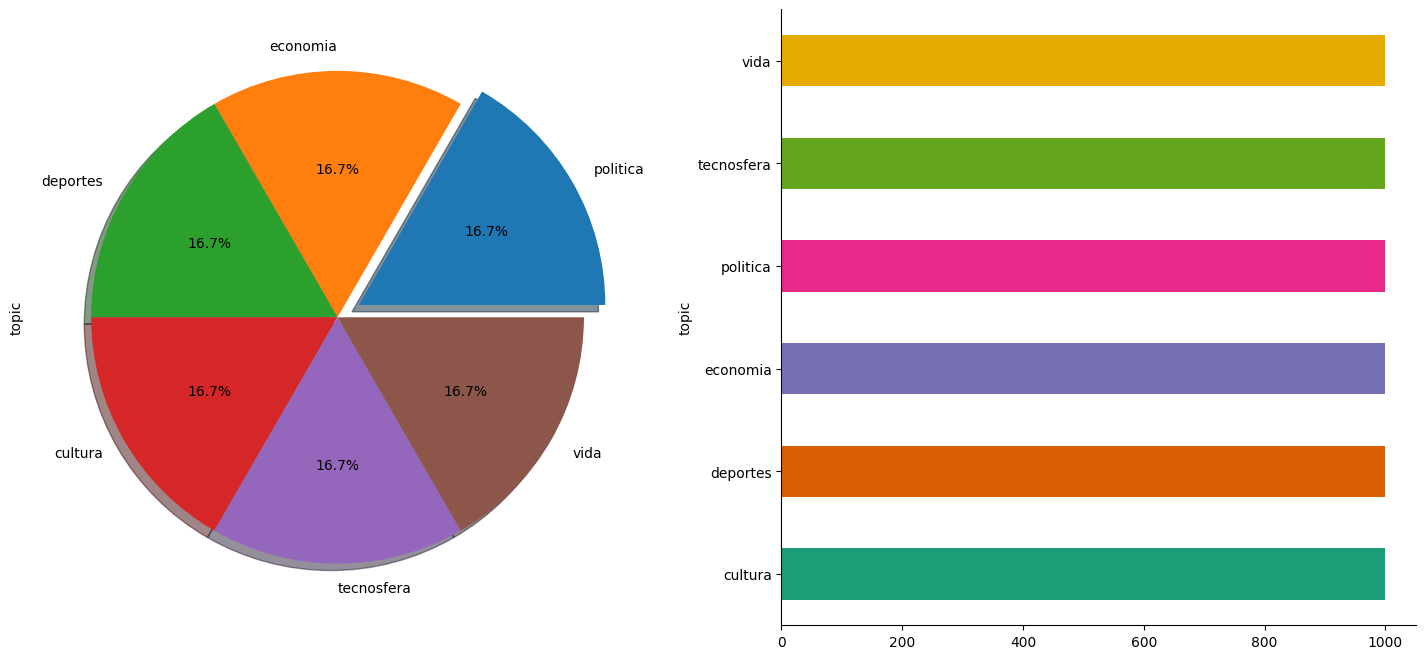

In [30]:
df =  pd.read_csv(r'balanceo_1000.csv')

f,ax=plt.subplots(1,2,figsize=(18,8))
df.topic.value_counts().plot.pie(explode=[0.1,0,0,0,0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
df =  pd.read_csv(r'balanceo_1000.csv')

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('topic').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['topic'])
df

,topic,text,date_query,categoryEncoded
0,politica,corte internacional justicia haya colombia tod...,2022-08-30T18:01:55.226Z,3
1,politica,domingo bogotanos vieron dos situaciones disti...,2022-01-17T19:04:23.376Z,3
2,politica,comicios año entra hechos escoger autoridades ...,2022-10-29T15:19:18.159Z,3
3,politica,llamada puerta giratoria permite congresistas ...,2022-12-13T19:33:30.008Z,3
4,politica,después roces ‘tostao’ grupo colombiano choqui...,2020-04-21T16:24:05.033Z,3
...,...,...,...,...
5995,vida,cansancio día inevitable ojos empiezan cerrar ...,2022-11-20T16:26:50.154Z,5
5996,vida,viajar parques universal unidos trasladarse lu...,2022-01-17T19:26:58.573Z,5
5997,vida,hace varios años ciudad deuda habitantes secto...,2020-11-30T18:41:19.146Z,5
5998,vida,semana santa periodo dedica religión católica ...,2022-04-08T20:37:50.892Z,5


**Split Dataset**

In [32]:
df['text_clean'] = df["text"].astype(str)

In [33]:
# split dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)
# get target
y_train = df_train["categoryEncoded"].values
y_test = df_test["categoryEncoded"].values

**BoW (Bag of Words)**

In [34]:
# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

In [ ]:
corpus = df_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_


**Feature Engineering**

In [ ]:
y = df_train["categoryEncoded"]
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "categoryEncoded":cat}))
    dtf_features = dtf_features.sort_values(["categoryEncoded","score"],
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["categoryEncoded"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["categoryEncoded"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 412
  . top features: cantante,compartida,publicación,publicación compartida,actriz,actor,artista,video,canción,película
 
# 1:
  . selected features: 545
  . top features: club,copa,equipo,fútbol,gol,liga,partido,selección,jugador,liverpool
 
# 2:
  . selected features: 513
  . top features: ciento,pesos,inflación,precios,tasa,economía,petróleo,dólar,billones,precio
 
# 3:
  . selected features: 517
  . top features: gustavo,gustavo petro,petro,presidente,paz,política,gobierno,coalición,congreso,duque
 
# 4:
  . selected features: 535
  . top features: apple,iphone,usuarios,whatsapp,google,facebook,dispositivos,aplicación,internet,dispositivo
 
# 5:
  . selected features: 366
  . top features: nasa,especies,espacial,tierra,luna,planeta,animales,cambio climático,climático,agua
 


**Training with ML Algorithm**

In [ ]:
# naive bayes
nb = naive_bayes.MultinomialNB()
# pipeline
model_nb = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("classifier", nb)])
# train classifier
model_nb["classifier"].fit(X_train, y_train)
# test
X_test = df_test["text_clean"].values
predicted_nb = model_nb.predict(X_test)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted_nb)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted_nb))

Accuracy: 0.89
Detail:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       316
           1       0.96      0.95      0.96       297
           2       0.85      0.89      0.87       306
           3       0.89      0.90      0.90       310
           4       0.91      0.93      0.92       281
           5       0.86      0.81      0.84       290

    accuracy                           0.89      1800
   macro avg       0.89      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800



In [ ]:
# logistic regression
lr = LogisticRegression(solver='liblinear')
# pipeline
model_lr = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("classifier", lr)])
# train classifier
model_lr["classifier"].fit(X_train, y_train)
# test
X_test = df_test["text_clean"].values
predicted_lr = model_lr.predict(X_test)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted_lr)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted_lr))

Accuracy: 0.91
Detail:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       316
           1       0.96      0.97      0.96       297
           2       0.90      0.87      0.88       306
           3       0.92      0.92      0.92       310
           4       0.93      0.99      0.96       281
           5       0.84      0.89      0.86       290

    accuracy                           0.91      1800
   macro avg       0.91      0.91      0.91      1800
weighted avg       0.91      0.91      0.91      1800



In [ ]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=2, random_state=4)
model_lgb = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("classifier", lgb_clf)])
model_lgb["classifier"].fit(X_train, y_train)
# test
X_test = df_test["text_clean"].values
predicted_lgb = model_lgb.predict(X_test)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted_lgb)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted_lgb))

Accuracy: 0.89
Detail:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       316
           1       0.94      0.96      0.95       297
           2       0.88      0.87      0.87       306
           3       0.91      0.91      0.91       310
           4       0.94      0.96      0.95       281
           5       0.78      0.84      0.81       290

    accuracy                           0.89      1800
   macro avg       0.89      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800



In [ ]:
xgb = xgboost.XGBRFClassifier(num_class=4,
                                  learning_rate=0.1,
                                  num_iterations=1000,
                                  max_depth=10,
                                  feature_fraction=0.7,
                                  scale_pos_weight=1.5,
                                  boosting='gbdt',
                                  metric='multiclass',
                                  eval_metric='mlogloss')
model_xgb = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("classifier", xgb)])
# train classifier
model_xgb["classifier"].fit(X_train, y_train)
# test
X_test = df_test["text_clean"].values
predicted_xgb = model_xgb.predict(X_test)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted_xgb)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted_xgb))

[16:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "boosting", "feature_fraction", "metric", "num_iterations", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\Users\Augusto Gomez\anaconda3\envs\nlp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       316
           1       0.92      0.92      0.92       297
           2       0.89      0.81      0.85       306
           3       0.86      0.88      0.87       310
           4       0.89      0.98      0.93       281
           5       0.75      0.80      0.78       290

    accuracy                           0.86      1800
   macro avg       0.86      0.86      0.86      1800
weighted avg       0.86      0.86      0.86      1800



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features=0.5, max_depth=15, random_state=1)

## pipeline
model_rf = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("rf", rf)])

## train classifier
model_rf["rf"].fit(X_train, y_train)
## test
X_test = df_test["text_clean"].values
predicted_rf = model_rf.predict(X_test)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted_rf)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted_rf))

Accuracy: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.80      0.66      0.73       316
           1       0.92      0.86      0.89       297
           2       0.83      0.68      0.75       306
           3       0.83      0.80      0.82       310
           4       0.87      0.89      0.88       281
           5       0.53      0.78      0.63       290

    accuracy                           0.78      1800
   macro avg       0.80      0.78      0.78      1800
weighted avg       0.80      0.78      0.78      1800



In [ ]:
knn = KNeighborsClassifier(n_neighbors=6)
model_knn = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("classifier", knn)])
# train classifier
model_knn["classifier"].fit(X_train, y_train)
# test
X_test = df_test["text_clean"].values
predicted_knn = model_knn.predict(X_test)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted_knn)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted_knn))

Accuracy: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       316
           1       0.93      0.97      0.95       297
           2       0.82      0.86      0.84       306
           3       0.92      0.86      0.89       310
           4       0.80      0.91      0.85       281
           5       0.82      0.78      0.80       290

    accuracy                           0.86      1800
   macro avg       0.86      0.86      0.86      1800
weighted avg       0.86      0.86      0.86      1800



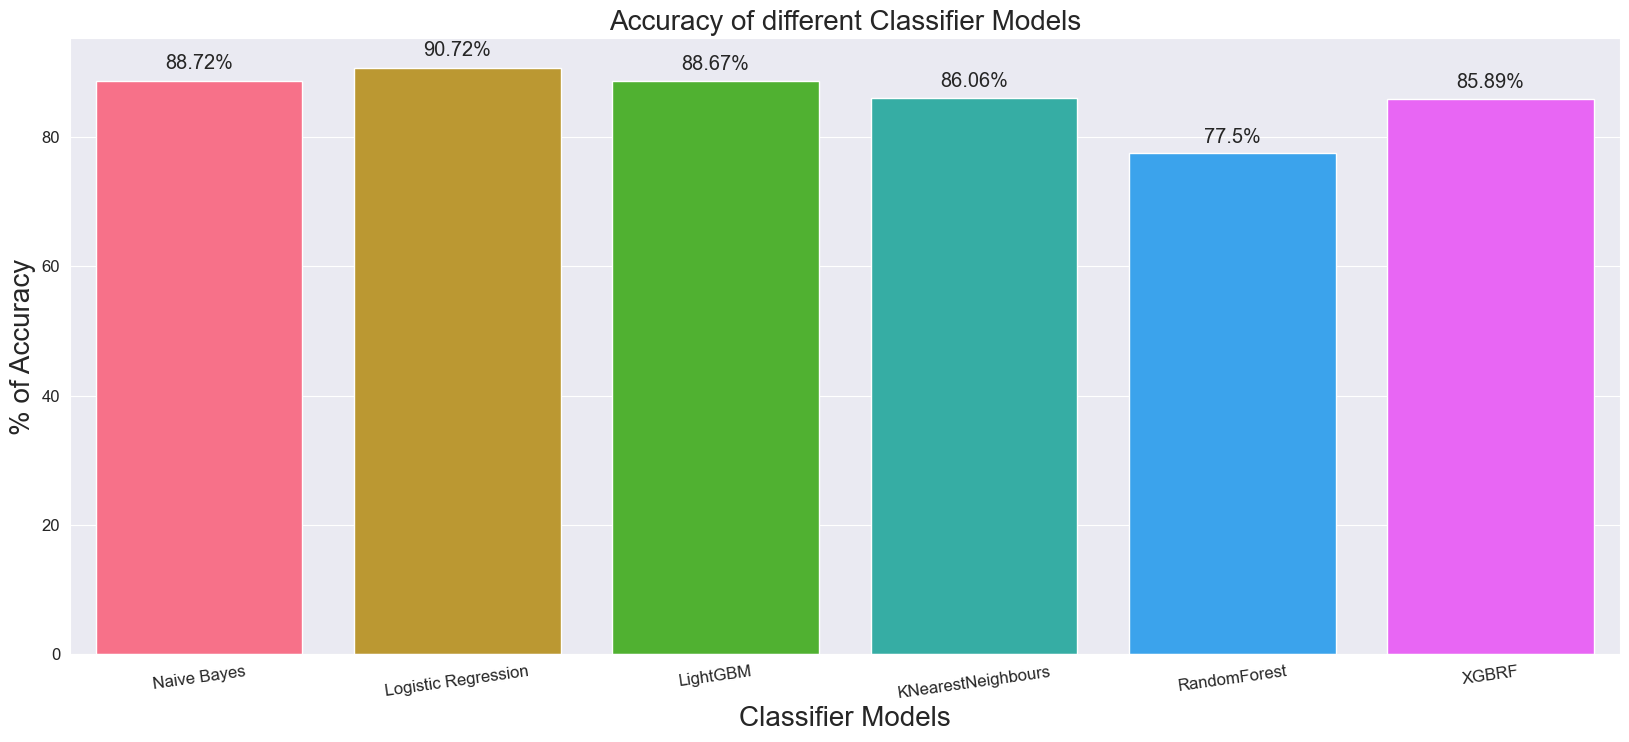

In [ ]:
model_list = ['Naive Bayes', 'Logistic Regression', 'LightGBM','KNearestNeighbours', 'RandomForest', 'XGBRF']
accuracy_list = [(metrics.accuracy_score(y_test, predicted_nb)*100), (metrics.accuracy_score(y_test, predicted_lr)*100),
                 (metrics.accuracy_score(y_test, predicted_lgb)*100), (metrics.accuracy_score(y_test, predicted_knn)*100),
               (metrics.accuracy_score(y_test, predicted_rf)*100), (metrics.accuracy_score(y_test, predicted_xgb)*100)]
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=accuracy_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Accuracy', fontsize = 20)
plt.title('Accuracy of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()